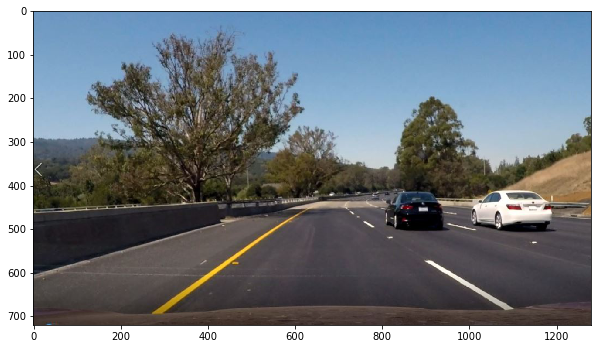

In [1]:
import threading
import os

import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip, concatenate_videoclips, ImageSequenceClip
from IPython.display import HTML
from tqdm import tqdm_notebook

from mylib import *

exec(open("./vehicleScan.py").read())
#from vehicleScan import *


n = 7
hot_frames = []
image = cv2.imread('./test_images/test'+str(n)+'.jpg')
image = cv2.resize(image, (1280, 720))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.show()


In [2]:
# function return progress string to print
def progress(cur_cnt, total_cnt):
    if cur_cnt > total_cnt:
        cur_cnt = total_cnt
    p = round(cur_cnt*100/total_cnt, 2)
    prg = "|"*(int(p))
    rem = " "*(int(100-p))
    print("\r"+"|>"+prg+rem+"<| "+str(cur_cnt)+"/"+str(total_cnt)+" "+str(p)+"% ", end='')

# Class used for multithreaded image processing
class myThread (threading.Thread):
    def __init__(self, tid, func, process_data, svc, Xscaler, frames):
        threading.Thread.__init__(self)
        self.target_func = func
        self.proc_data = process_data
        self.svc = svc
        self.scaler = Xscaler
        self.ip_frames = frames
        self.tid = tid
    
    # run specific task of processing all the recieved frames
    def run(self):
        global op_parts, frames_processed, frm_cnt
        op_frs = []
        for frame in self.ip_frames:
            op_frs.append((frame.image, self.target_func(frame.image, self.svc, self.scaler, self.proc_data)))
            frames_processed += 1
            progress(frames_processed, frm_cnt)
        op_parts[self.tid-1] = op_frs

# Class to store data related to a frame
class VideoFrame:
    fcnt = 0
    def __init__(self, image):
        VideoFrame.fcnt += 1
        self.image = image
        self.frame_no = VideoFrame.fcnt
        self.h = image.shape[0]
        self.w = image.shape[1]

# Process each frame by averaging the heat map and drawing bounding boxes over cars
def process_frames(frame_seq):
    hot_frames = []
    op_seq = []
    for ind in tqdm_notebook(range(len(frame_seq))):
        img, heat_map = frame_seq[ind]
        nheat_map = np.zeros_like(heat_map)
        nheat_map.astype(np.int)
        fln = len(hot_frames)
        for i in range(fln):
            nheat_map = nheat_map + hot_frames[i]
        nheat_map = (nheat_map + heat_map)/(fln+1)
        # remove unwanted heat by thresholding
        nheat_map = cool_heat(nheat_map, 12)
        # normalize the heat
        nheat_map = 255*(nheat_map/np.max(nheat_map))
        nheat_map.astype(np.uint8)
        nheat_map = cv2.GaussianBlur(nheat_map, (3,3), 0)
        
        # add frame to buffer
        hot_frames.append(cool_heat(heat_map, 13))
        if len(hot_frames) > 8:
            hot_frames.pop(0)
        # generate labels for hot boxes
        labels = label(nheat_map)
        op = draw_labeled_bboxes(img, labels)
        mini_hm = cv2.resize(nheat_map, (360, 240))
        mini_hm = np.dstack((mini_hm, np.zeros_like(mini_hm), np.zeros_like(mini_hm)))
        op[0:240, op.shape[1]-360:op.shape[1]] = mini_hm
        op_seq.append(op)
    return op_seq

In [ ]:
# global variables for output video
fps = None

# global variables for processing video
all_frames = []    # all the frames in original video
vid = "project"
# get fps and frame from the input video
output_vid = "./output_videos/"+vid+"_video_mt.mp4"
in_clip = VideoFileClip(vid+"_video.mp4")
fps = in_clip.fps

# Read all the frames into memory along with frame numbers
all_frames = [ VideoFrame(frame) for frame in in_clip.iter_frames() ]
frm_cnt = len(all_frames)

# Processing variables
proc_data={
    "orient" : 11,
    "pix_per_cell" : 8,
    "cell_per_block" : 2,
    "spatial" : 16,
    "hbins" : 32,
    "overlap" : 0.875,
    "inc_spatial" : True,
    "inc_hist" : True,
    # training image size
    "trained_win_size" : 64,
    # list of windows for each window size
    "windows" : {80: Window()},
    "frame_height" : all_frames[0].h,
    "frame_width" : all_frames[0].w
}
print("Read "+str(len(all_frames))+" frames at "+str(fps)+" fps.")

# vertical scanning area
y_fullrange_img = [((proc_data["frame_height"]//2)//64)*64, proc_data["frame_height"]-48]
# image scanning area height
y_len = y_fullrange_img[1] - y_fullrange_img[0]
# range_offsets along x-axis for each window
x_offset = {80:0}#proc_data["frame_width"]//8}
# range_offsets along y-axis for each window
y_offset = {80:0}

##### Create all the Windows
for win_size in proc_data["windows"]:
    proc_data["windows"][win_size].windows
    # scan range for y-axis
    y_range_img = [y_fullrange_img[0] + y_offset[win_size]+50, y_fullrange_img[1] - y_offset[win_size]]
    # get x range for search
    x_range_img = [x_offset[win_size]+(7*proc_data["frame_width"]//16),
                   proc_data["frame_width"] - x_offset[win_size]]
    proc_data["windows"][win_size].windows = get_windows(all_frames[0].image, x_start_stop=x_range_img, y_start_stop=y_range_img,
                                        xy_window=(win_size, win_size),
                                        xy_overlap=(proc_data["overlap"], proc_data["overlap"]))
    proc_data["windows"][win_size].x_range_img = x_range_img
    proc_data["windows"][win_size].y_range_img = y_range_img
print("Frame dimensions (w x h):", (all_frames[0].image.shape[:2])[::-1])
print("Created required Windows to scan.")


Read 1260 frames at 25.0 fps.
Frame dimensions (w x h): (1280, 720)
Created required Windows to scan.


In [ ]:
svc = joblib.load('svm_model.pkl')
X_scaler = joblib.load('svm_scaler.pkl')

cpu_cnt = os.cpu_count()
if cpu_cnt is None:
    cpu_cnt = 4
no_threads = 1

# each thread will place output in its respective slot (by using Thread Id as index)
op_parts = [None]*no_threads
# all the worker threads
proc_threads = [None]*no_threads
frm_per_thread = frm_cnt//no_threads  # number of frames to process by each thread
frames_processed = 0

print("Starting "+str(no_threads)+" worker threads ..")
# each thread will place output in its respective slot (by using Thread Id as index)
t0 = time.time()
op_parts = [None]*no_threads
# Create and start new threads
for i in range(no_threads):
    st = i*frm_per_thread
    ed = (i+1)*frm_per_thread
    if i == no_threads-1:
        ed = frm_cnt-1
    proc_threads[i] = myThread(i+1, process_image, proc_data, svc, X_scaler, all_frames[st:ed+1])
    proc_threads[i].start()


for i in range(no_threads):
    proc_threads[i].join()
t1 = time.time()
'''
t0 = time.time()
op_frs = []
for frame in all_frames:
    op_frs.append((frame.image, process_image(frame.image, svc, X_scaler, proc_data)))
    frames_processed += 1
    progress(frames_processed, frm_cnt)
    op_parts[0] = op_frs
t1 = time.time()
'''
print("\nThreads finished processing in",round((t1-t0), 2),"seconds.")


Starting 1 worker threads ..
|>|||                                                                                                <| 50/1260 3.97% 

In [ ]:
# Generate averaged and thresholded heatmap from the outputs
print("Generating Output video")
t0 = time.time()
clip_seq = []
for part in op_parts:
    clip_seq += part
clip_seq = process_frames(clip_seq)
new_clip = ImageSequenceClip(clip_seq, fps=fps)
new_clip.write_videofile(output_vid)
t1 = time.time()
print("Video Created in ",round((t1-t0), 2),"seconds.")

In [ ]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format(output_vid))